In [ ]:
!pip install scanpy==1.10.2 anndata==0.10.8 umap-learn==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 pynndescent==0.5.13 h5py==3.9.0


In [ ]:
!pip install igraph

In [ ]:
!pip install leidenalg


In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pooch

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [ ]:
adata = sc.read_h5ad("dataset.h5ad")

In [ ]:
gene_names = pd.read_csv('gene_names.csv', header=None)

In [ ]:
if len(gene_names) == adata.shape[1] + 1:
    gene_names = gene_names.iloc[1:]
adata.var_names = gene_names[0].values

# Quality Control(QC)

In [ ]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

In [ ]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(axis=1) / adata.obs['n_counts']

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

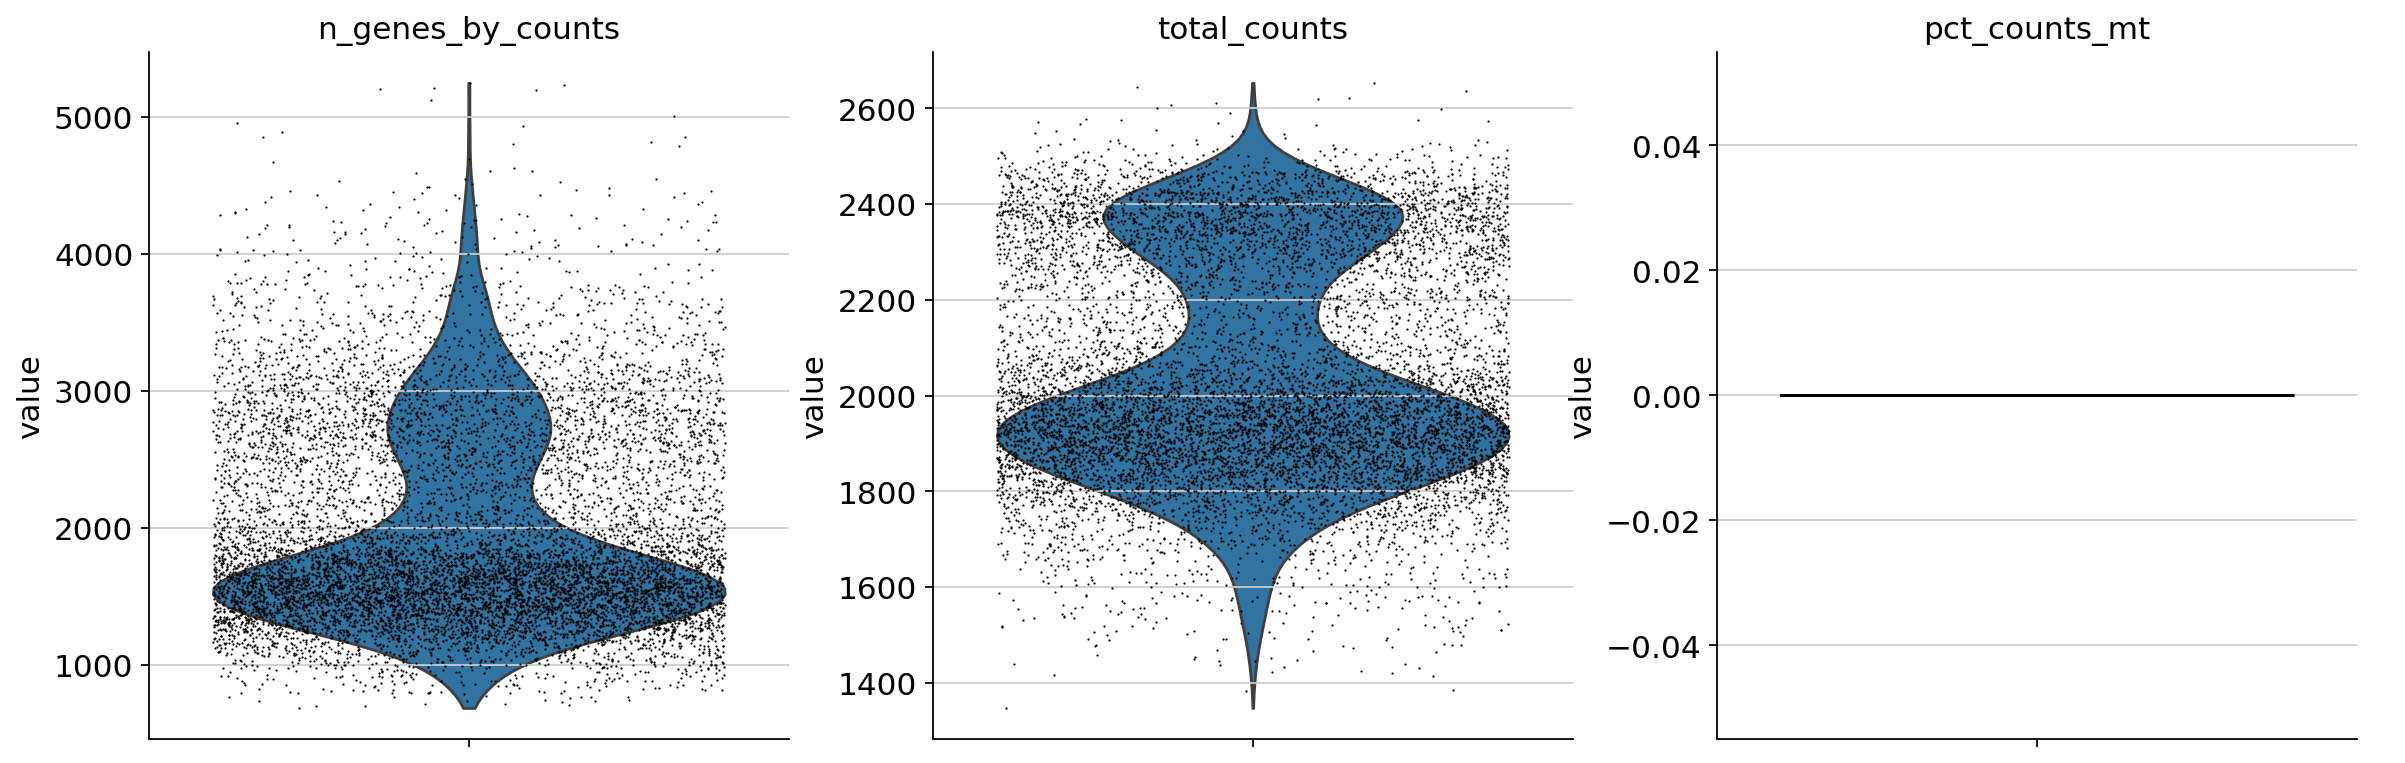

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

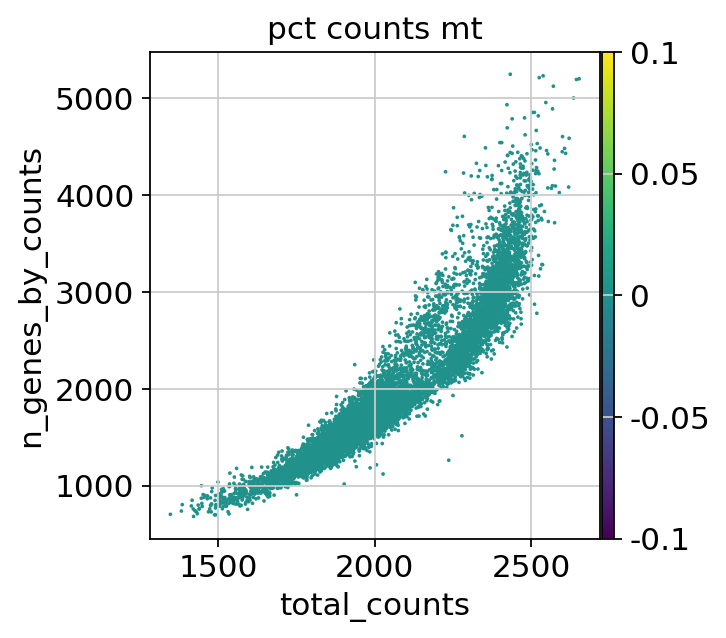

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 74 genes that are detected in less than 3 cells


In [ ]:
sc.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 69.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.2%
    Scrublet finished (0:01:46)


In [ ]:
adata.layers["counts"] = adata.X.copy()

# Normalize and Log Transform

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


# Feature Selection and PCA

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


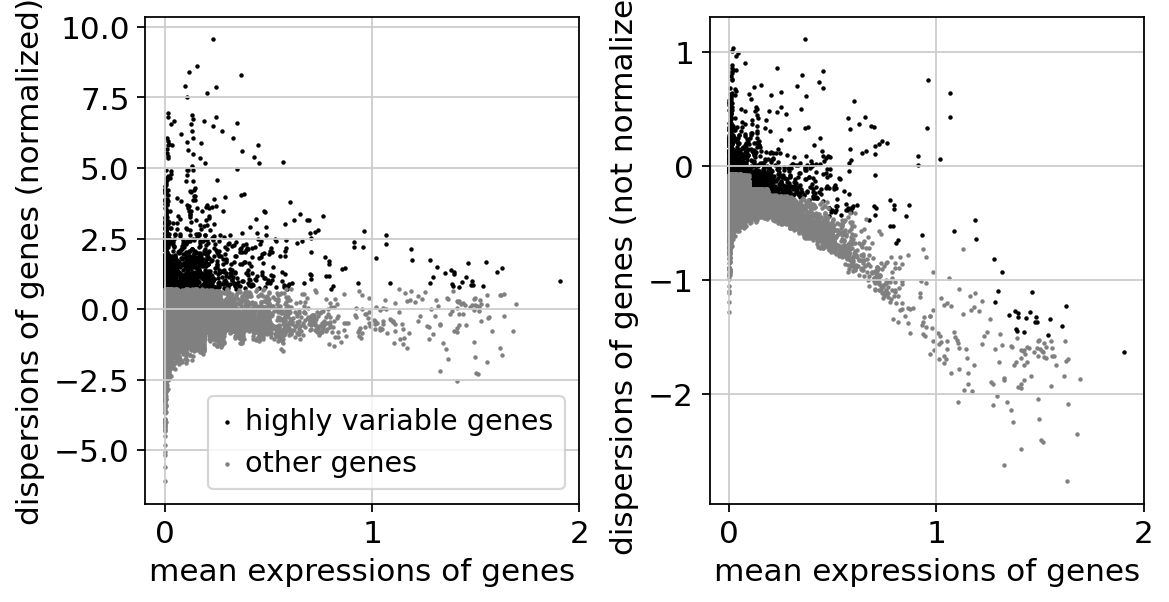

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:04)


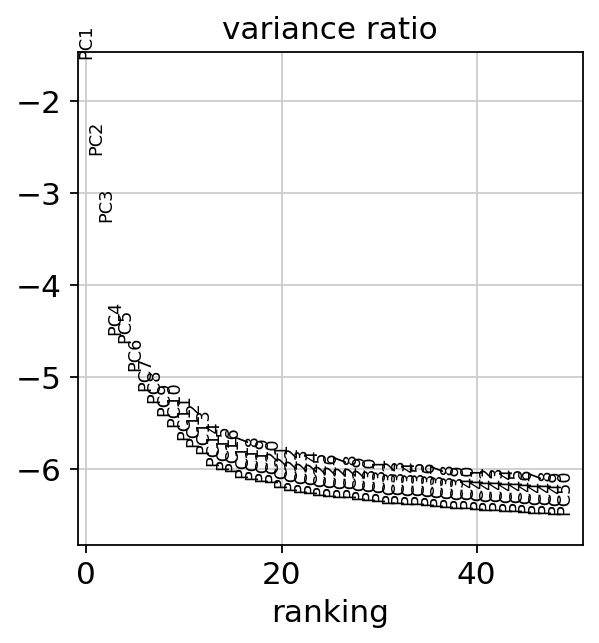

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [ ]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


# Leiden Clustering

In [ ]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=-1)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


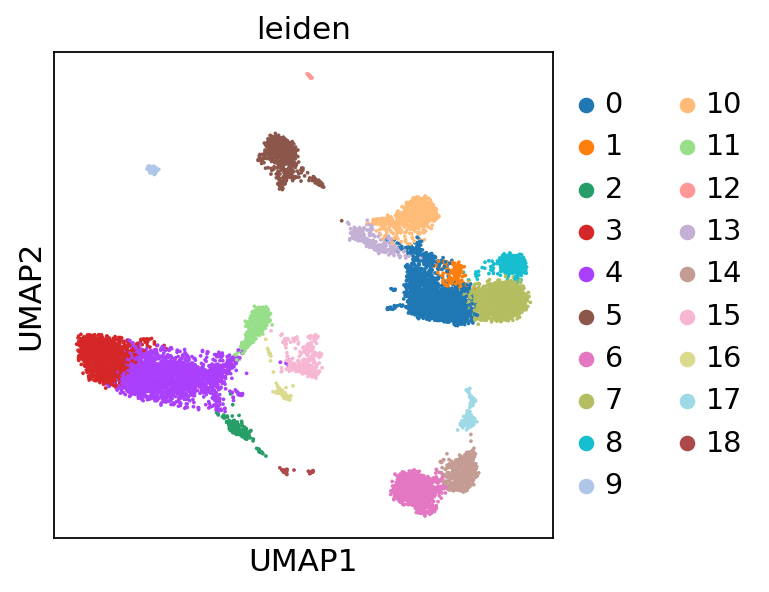

In [ ]:
sc.pl.umap(adata, color=["leiden"])

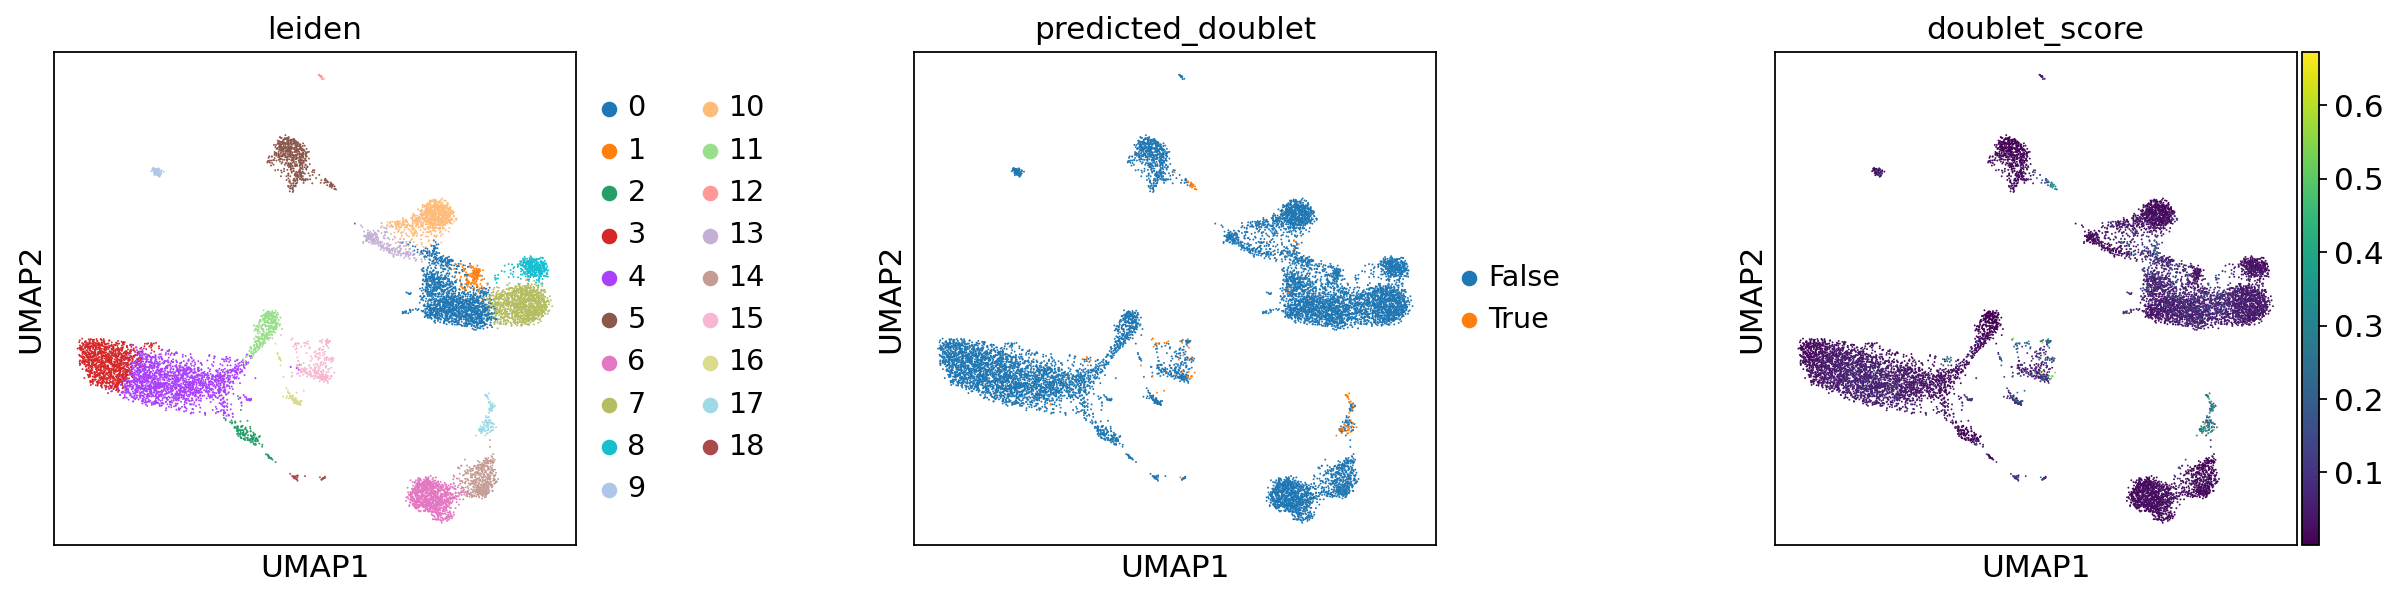

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [ ]:
for res in [0.25, 0.5,0.75, 1.0]:
  res_str = f"{res:.2f}".replace('.', '_')
  sc.tl.leiden(
        adata, key_added=f"leiden_res_{res_str}", resolution=res, flavor="igraph"
    )

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0_25', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_res_0_50', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_res_0_75', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_res_1_00', the cluster labels (adata.obs, categorical) (0:00:00)


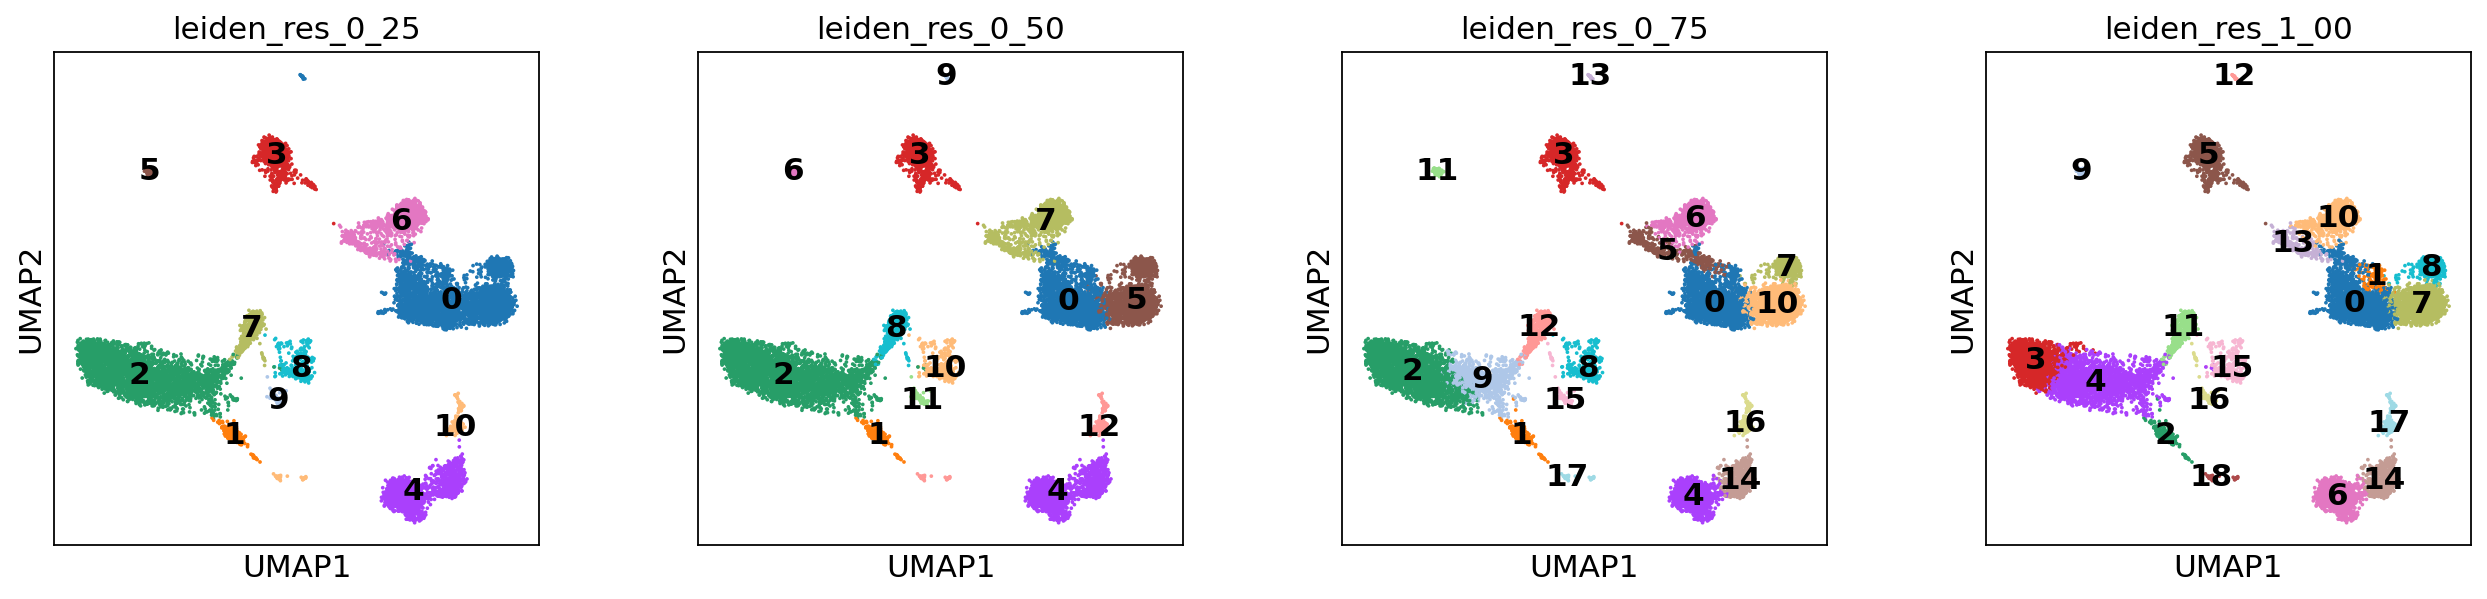

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden_res_0_25", "leiden_res_0_50","leiden_res_0_75", "leiden_res_1_00"],
    legend_loc="on data",
)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0_50", method="wilcoxon", key_added = "dea_leiden_0_5")

ranking genes
    finished: added to `.uns['dea_leiden_0_5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0_50']`


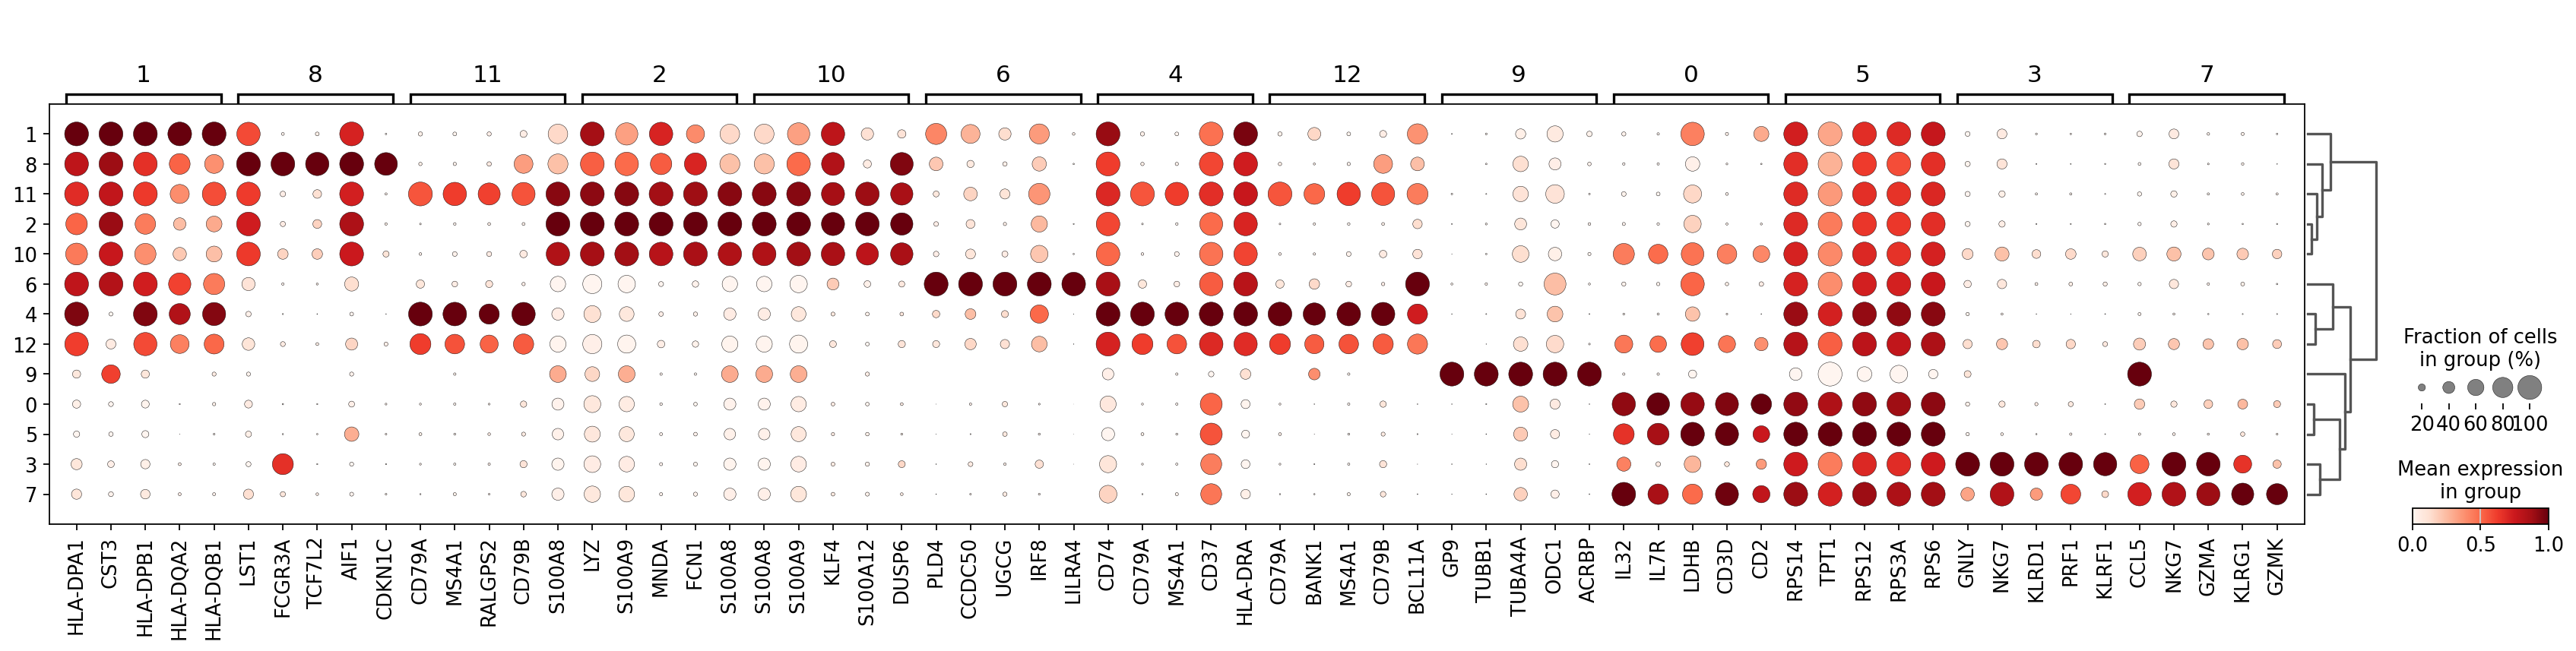

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0_50", standard_scale="var", n_genes=5, key="dea_leiden_0_5"
)

In [ ]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
     key="dea_leiden_0_5",
    key_added="filtered0_5",
    )

Filtering genes using: min_in_group_fraction: 0.2 min_fold_change: 1, max_out_group_fraction: 0.2


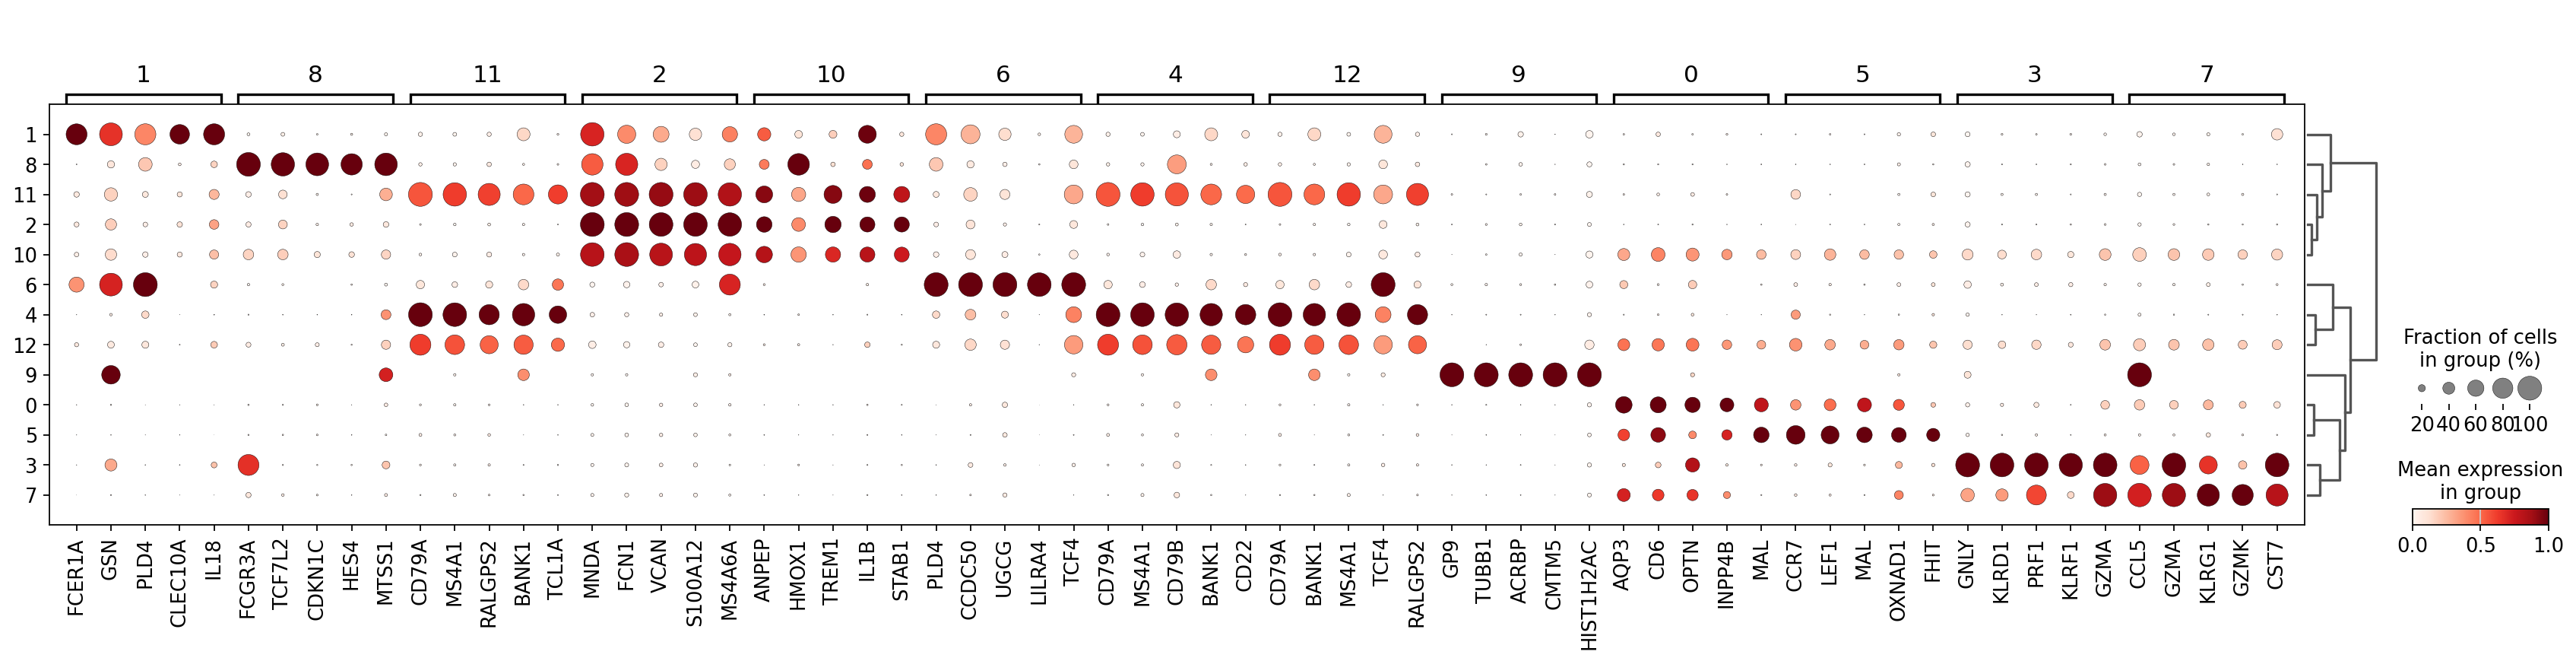

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0_50", standard_scale="var", n_genes=5, key="filtered0_5"
)

# Annotation

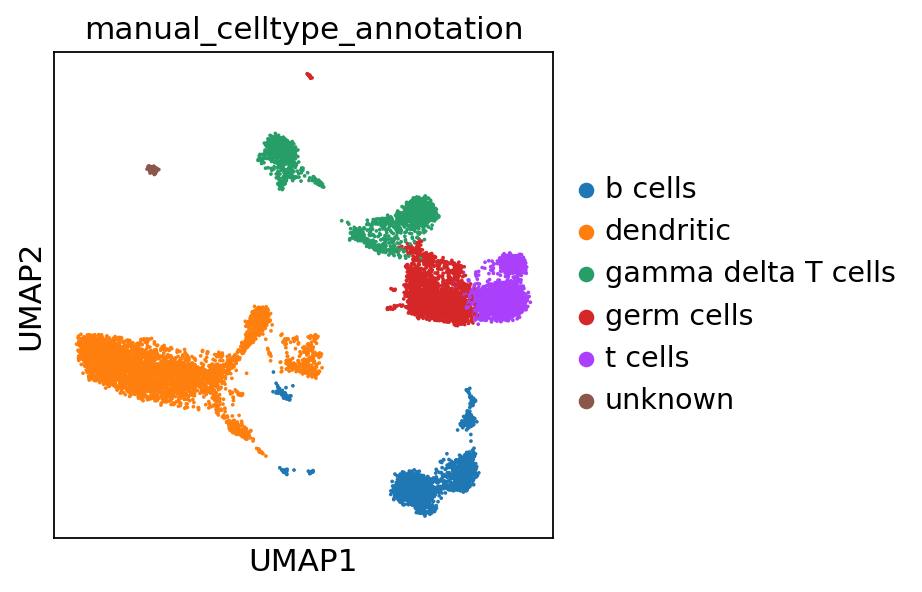

In [ ]:
cl_annotations = {
    '1': "dendritic", '2': "dendritic", '0': "germ cells", '3': "gamma delta T cells", '4': "b cells",
    '5': "t cells", '6': "unknown", '7': "gamma delta T cells", '8': "dendritic", '9': "germ cells",
    '10': "dendritic", '11': "b cells", '12': "b cells"
}


adata.obs["manual_celltype_annotation"] = adata.obs['leiden_res_0_50'].map(cl_annotations)


adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].fillna("unknown")


sc.pl.umap(
    adata,
    color=["manual_celltype_annotation"],
)

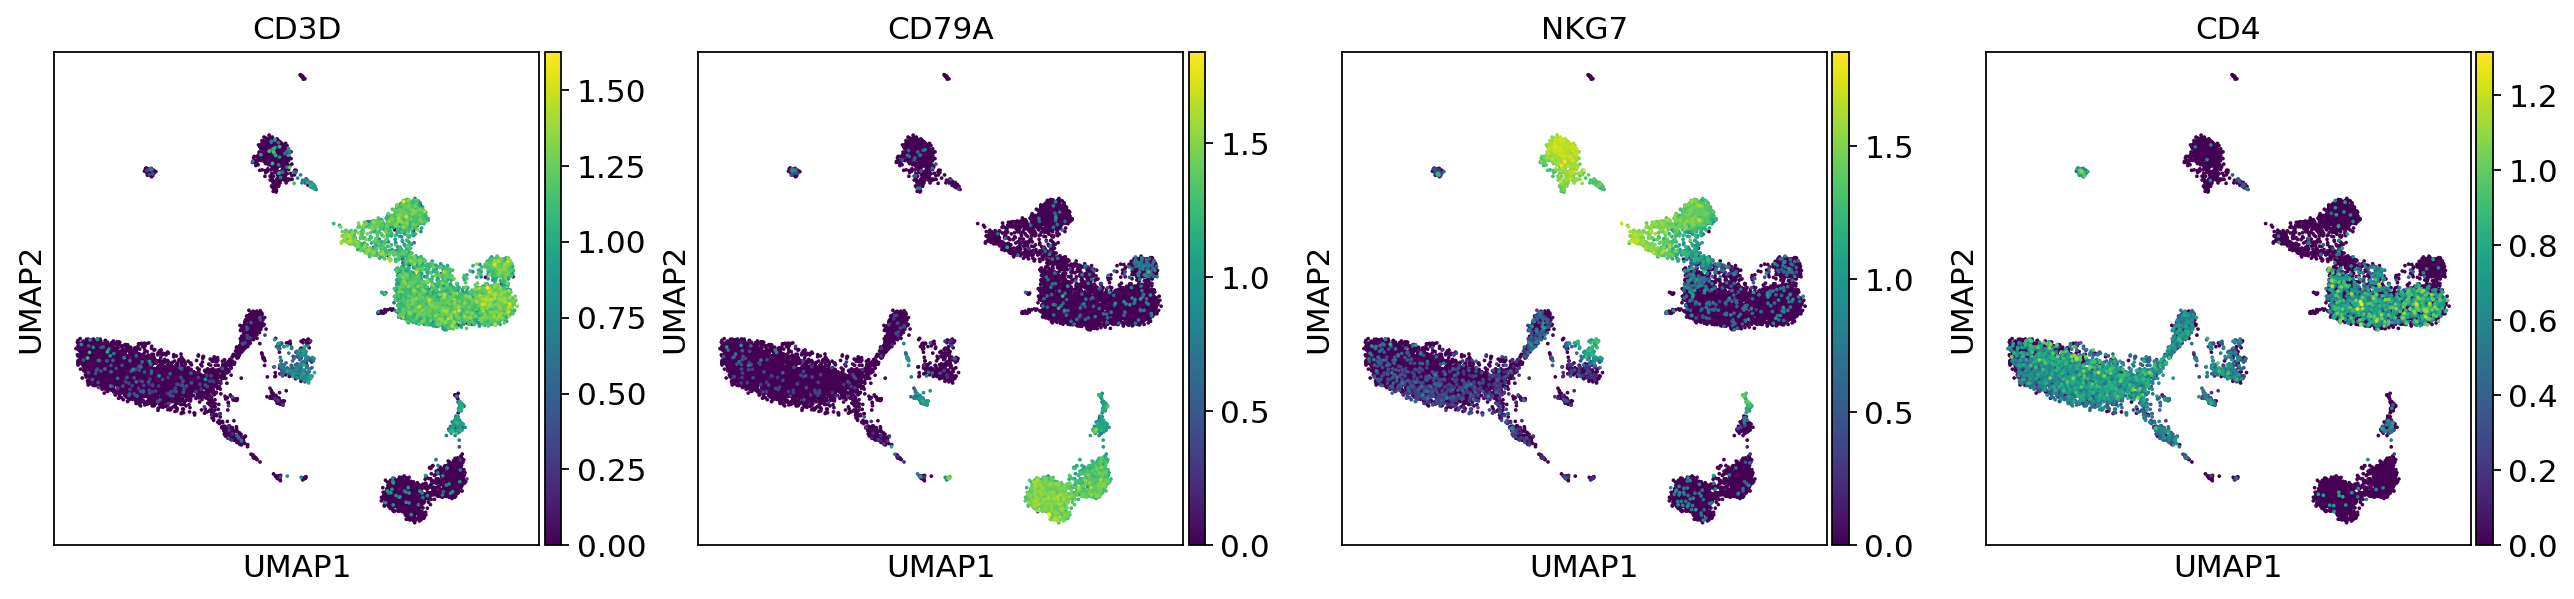

In [ ]:
sc.pl.umap(adata, color=["CD3D", "CD79A", "NKG7","CD4"])